In [2]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

numb_batch = 64
test_folder="./Train"

In [4]:
# Instancia um Compose com diversos transforms, dentre eles:
    # Transforma a imagem para Tensor
    # Transforma a imagem para 28x28
    # Transforma a imagem para Grayscale (tons de cinza)
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((28,28), antialias=True),
    torchvision.transforms.Grayscale(num_output_channels=1)
])

# Instancia Datasets Mnist para treinamento e validação
# Para isso, realiza o download do dataset
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

# Busca imagens do parâmetro root e adiciona no dataset de treinamento
# local_train_data = torchvision.datasets.ImageFolder(root=test_folder, transform=T)
# train_data= torch.utils.data.ConcatDataset([train_data, local_train_data])

# Instancia Dataloaders de Treinamento e Validação
train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)


In [5]:
# Método que define o Modelo
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [6]:
# Método para realizar a validação da predição durante o treinamento
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [7]:
# Valida se utilizará o cuda (gpu dedicada) ou a cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [8]:
# Método de Treinamento
def train(numb_epoch=3, lr=0.001, device=device):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  96.33999633789062
Epoch: 1 Accuracy : 96.33999633789062 %
Saving Best Model with Accuracy:  97.69999694824219
Epoch: 2 Accuracy : 97.69999694824219 %
Saving Best Model with Accuracy:  97.94999694824219
Epoch: 3 Accuracy : 97.94999694824219 %
Saving Best Model with Accuracy:  98.3499984741211
Epoch: 4 Accuracy : 98.3499984741211 %
Saving Best Model with Accuracy:  98.52999877929688
Epoch: 5 Accuracy : 98.52999877929688 %
Saving Best Model with Accuracy:  98.54000091552734
Epoch: 6 Accuracy : 98.54000091552734 %
Saving Best Model with Accuracy:  98.73999786376953
Epoch: 7 Accuracy : 98.73999786376953 %
Epoch: 8 Accuracy : 98.6500015258789 %
Saving Best Model with Accuracy:  98.77999877929688
Epoch: 9 Accuracy : 98.77999877929688 %
Saving Best Model with Accuracy:  98.86000061035156
Epoch: 10 Accuracy : 98.86000061035156 %
Epoch: 11 Accuracy : 98.7699966430664 %
Epoch: 12 Accuracy : 98.7699966430664 %
Saving Best Model with Accuracy:  98.87999725341797
Ep

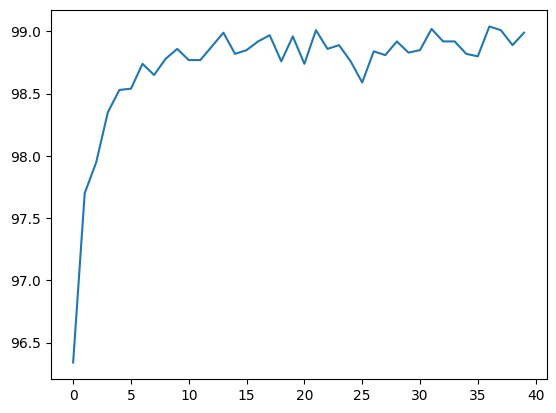

In [100]:
lenet = train(40, device=device)

In [109]:
torch.save(lenet, "lenet.pth")

In [9]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [104]:
# Validando o Modelo
y_pred, y_true = predict_dl(lenet, val_dl)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,974,1,2,0,0,0,0,1,2,0
1,0,1134,0,0,0,0,0,0,1,0
2,0,1,1028,0,1,0,0,1,1,0
3,0,1,4,999,0,2,0,1,3,0
4,0,0,1,0,973,0,3,0,0,5
5,2,1,0,6,0,878,1,0,3,1
6,1,3,0,0,3,1,950,0,0,0
7,1,2,5,0,1,0,0,1016,1,2
8,2,0,1,1,0,0,0,0,967,3
9,1,1,0,1,8,5,0,5,3,985


In [10]:
# Método para realizar a predição de uma imagem da web
def inference_web_image(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy(), x

In [11]:
# Método para realizar a predição de uma imagem local
def inference_local_image(path, model, device):
    img = Image.open(path).convert(mode="L")
    img = img.resize((28, 28))
    x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy(), x

In [12]:
# Carregar modelo local, caso já tenha
if torch.cuda.is_available():
    lenet = torch.load('modelo.pth')
else:
    lenet = torch.load('modelo.pth', map_location=torch.device('cpu'))

Predicted: 1, Prob: 99.87574815750122 %


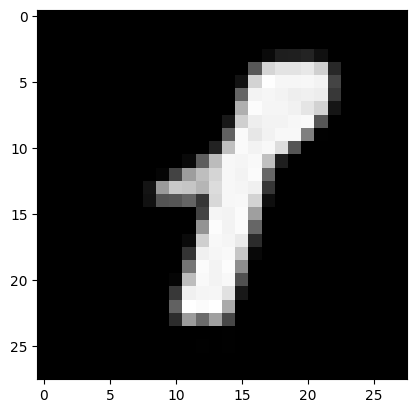

In [14]:
# Inferir com Imagem da Web
# path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSq2h_xaDtemhitxk1AhEyzc5mYQu17d3Qb9Q&s"
# pred, x = inference_web_image(path, lenet, device=device)

# Inferir com Imagem Local
path = "./Test/1/Captura de tela 2024-06-16 211935.png"
pred, x = inference_local_image(path, lenet, device=device)

plt.imshow(x.squeeze(-1), cmap="gray")
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")
# print(pred)